# Description:

This is my personal Python classification project.

- Conducted a quick Exploratory Data Analysis (EDA) for initial observations of dataset characteristics.
- Utilized an imputer to fill missing data, ensuring a comprehensive dataset.
- Applied a scaler for improved accuracy in data representation.
- These steps, including thorough data exploration, effective handling of missing values, and optimization for accurate predictions, collectively contribute to a robust foundation for the classification model.


## Dataset: 

dataset : https://www.kaggle.com/datasets/adityakadiwal/water-potability

## #1. Importing Data

In [24]:
import pandas as pd 
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [25]:
data_water = pd.read_csv("../data/water_quality_prediction_data/water_potability.csv", index_col=None)
data_ori = data_water.copy()

### In terms of potability, a value of 1 indicates potable water, while a value of 0 indicates non-potable water

In [26]:
# Quck overview of the data
data_water.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


## #2. Evaluate Data Integrity and Address Missing Values

In [27]:
# Identify a missing data
data_water.isnull().sum()/len(data_water)

ph                 0.149878
Hardness           0.000000
Solids             0.000000
Chloramines        0.000000
Sulfate            0.238400
Conductivity       0.000000
Organic_carbon     0.000000
Trihalomethanes    0.049451
Turbidity          0.000000
Potability         0.000000
dtype: float64

In [28]:
# Validate for duplicate data entries
data_water.duplicated().sum()

0

    The chosen percentage threshold for handling missing values in this analysis is set at 20%. Consequently, the 'Sulfate' column has been dropped from the dataset. This decision ensures that variables with missing values exceeding the defined threshold are appropriately managed in the analysis

In [29]:
target = 'Potability'
missing = 'Sulfate'

data_water.drop(columns=missing, inplace=True)
X, y = data_water.drop(columns=target), data_water[target]

X2, y2 = X,y

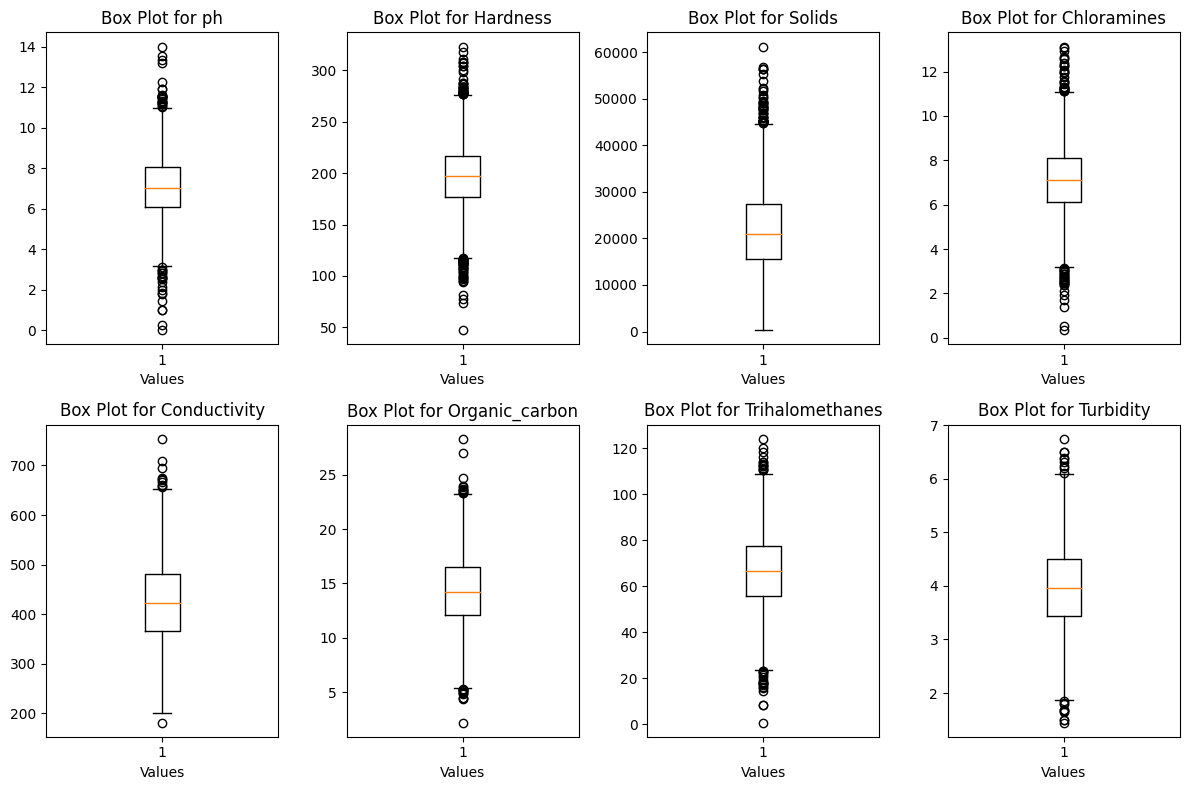

In [30]:
# Set the figure size for the subplots
plt.figure(figsize=(12,8))

# Iterate through the columns and create individual box plots
for i, column in enumerate(X.columns, 1):
    plt.subplot(2, len(X.columns) //2, i)  # Create a subplot for each column
    plt.boxplot(X[column].dropna())
    plt.title(f'Box Plot for {column}')
    plt.xlabel('Values')
    plt.ylabel('')

plt.tight_layout()  # Adjust subplot spacing

plt.show()

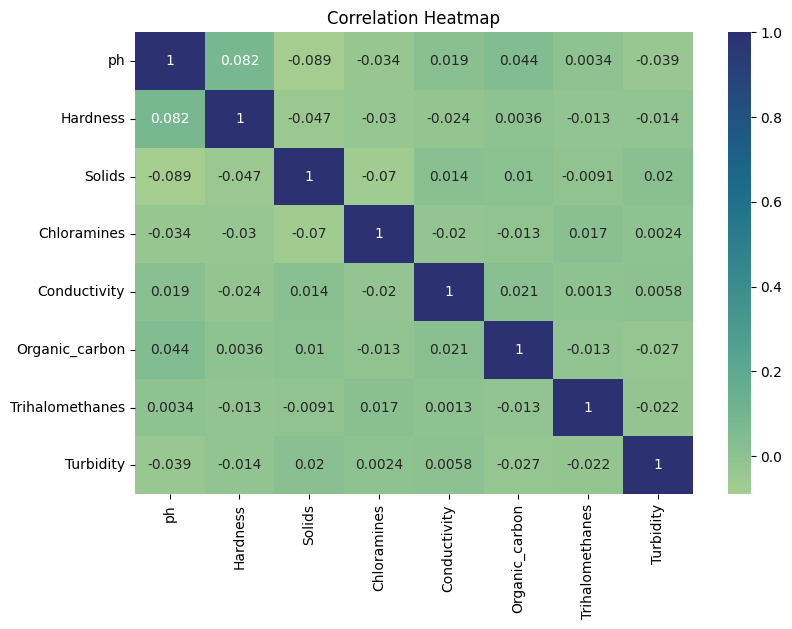

In [31]:

plt.figure(figsize=(9, 6))
sns.heatmap(X.corr(), annot=True, cmap='crest')
plt.title('Correlation Heatmap')

plt.show()

    NOTE: 
    
    Unless we use pipeline , all preprocessing method should be  performed separately on the training and testing sets to avoid information leakage.  

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.impute import KNNImputer # preprocessing for missing value
from imblearn.over_sampling import SMOTE # preprocessing for oversampling
from sklearn.preprocessing import RobustScaler # preprocessing for Standardization
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA # preprocessing for feature reduction
 #classifiers
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.pipeline import make_pipeline # pipeline

# List of classifiers to evaluate
classifiers = [
    KNeighborsClassifier(),
    DecisionTreeClassifier(random_state=33),
    RandomForestClassifier(random_state=33),
    SVC(random_state=33),
    GaussianNB(),
    LogisticRegression(random_state=33)
]


X_imputed = KNNImputer(missing_values=np.nan).fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, random_state=33)

X_train_resampled, y_train_resampled = SMOTE(random_state=33).fit_resample(X_train, y_train)


In [33]:
for classifier in classifiers:
    print("\nName of classifier:" , classifier, "\n")

    pipe = make_pipeline(
        RobustScaler(),
        PCA(n_components=4),
        classifier
        )
    pipe.fit(X_train_resampled, y_train_resampled)
    test_accuracy = pipe.score(X_test, y_test)

    pipe.fit(X_train, y_train)
    test_accuracy_wo = pipe.score(X_test, y_test)

    print("Testing Accuracy with oversampling method:", test_accuracy)
    print("Testing Accuracy without oversampling method:", test_accuracy_wo)


    # Perform cross-validation
    cv_accuracy = cross_val_score(pipe, X_imputed, y, cv=20).mean()
    print("Cross-Validation Mean Accuracy without oversampling method:", cv_accuracy)

#NOTE: running time on random forest longer than other methods


Name of classifier: KNeighborsClassifier() 

Testing Accuracy with oversampling method: 0.5445665445665445
Testing Accuracy without oversampling method: 0.5616605616605617
Cross-Validation Mean Accuracy without oversampling method: 0.5772201855454138

Name of classifier: DecisionTreeClassifier(random_state=33) 

Testing Accuracy with oversampling method: 0.525030525030525
Testing Accuracy without oversampling method: 0.5714285714285714
Cross-Validation Mean Accuracy without oversampling method: 0.5632014065539429

Name of classifier: RandomForestClassifier(random_state=33) 

Testing Accuracy with oversampling method: 0.5518925518925519
Testing Accuracy without oversampling method: 0.5958485958485958
Cross-Validation Mean Accuracy without oversampling method: 0.599513691455933

Name of classifier: SVC(random_state=33) 

Testing Accuracy with oversampling method: 0.5274725274725275
Testing Accuracy without oversampling method: 0.6507936507936508
Cross-Validation Mean Accuracy without ov

##  TAKEAWAYS: 

This is my first time using the oversampling method in the analysis. Unfortunately, Overall accuracy of oversampled data was significanlty worse than original scaled data. I thought this was good approach since the sample has unbalance predict value. To effectively utilize oversampling in future work, additional information is needed.

possible reason: overfitting

Furthermore, I will select three classifiers with higher cross-validation scores and conduct in-depth analysis on them. 

 I have selected Support Vector Classifier (SVC), Gaussian Naive Bayes (GaussianNB), and Logistic Regression for further analysis.

Accuracy score for SVC(random_state=33) on standard scaled data:  0.5274725274725275
Precision score for SVC(random_state=33) on standard scaled data:  0.41735537190082644

[[230 282]
 [105 202]]

              precision    recall  f1-score   support

           0       0.69      0.45      0.54       512
           1       0.42      0.66      0.51       307

    accuracy                           0.53       819
   macro avg       0.55      0.55      0.53       819
weighted avg       0.59      0.53      0.53       819



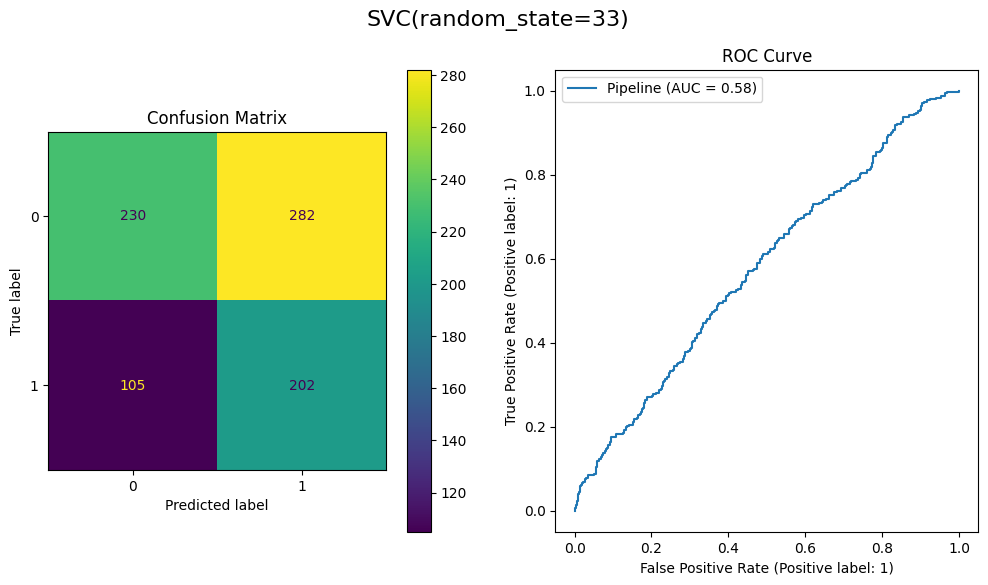



Accuracy score for GaussianNB() on standard scaled data:  0.5506715506715507
Precision score for GaussianNB() on standard scaled data:  0.4344086021505376

[[249 263]
 [105 202]]

              precision    recall  f1-score   support

           0       0.70      0.49      0.58       512
           1       0.43      0.66      0.52       307

    accuracy                           0.55       819
   macro avg       0.57      0.57      0.55       819
weighted avg       0.60      0.55      0.56       819



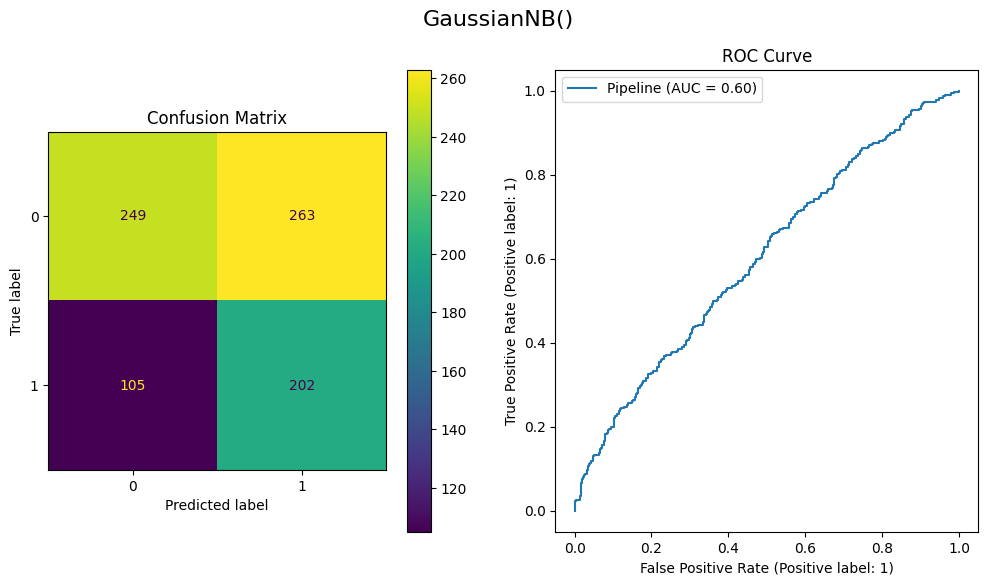



Accuracy score for LogisticRegression(random_state=33) on standard scaled data:  0.5006105006105006
Precision score for LogisticRegression(random_state=33) on standard scaled data:  0.37185929648241206

[[262 250]
 [159 148]]

              precision    recall  f1-score   support

           0       0.62      0.51      0.56       512
           1       0.37      0.48      0.42       307

    accuracy                           0.50       819
   macro avg       0.50      0.50      0.49       819
weighted avg       0.53      0.50      0.51       819



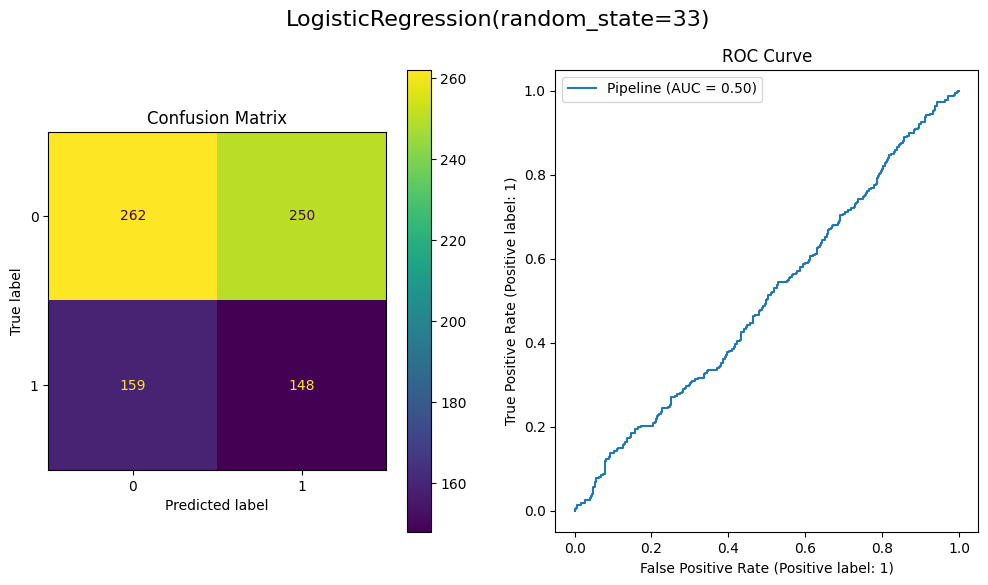

In [87]:
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score, confusion_matrix, classification_report, RocCurveDisplay

# first check with  logistic regression on standard scaled data

top_classifiers = [
    SVC(random_state=33),
    GaussianNB(),
    LogisticRegression(random_state=33)
]

for classifier in top_classifiers:

    pipe = make_pipeline(
        RobustScaler(),
        PCA(n_components=4),
        classifier
        )
    pipe.fit(X_train_resampled, y_train_resampled)

    y_pred = pipe.predict(X_test)
    print('Accuracy score for' ,classifier, 'on standard scaled data: ', accuracy_score(y_test, y_pred))
    print('Precision score for' ,classifier, 'on standard scaled data: ', precision_score(y_test, y_pred))
    print()
    print(confusion_matrix(y_test, y_pred))
    print()
    print(classification_report(y_test, y_pred))
    # support: The number of occurrences of each label in y_true.

    fig, [ax_con, ax_roc] = plt.subplots(1, 2, figsize=(12, 6))

    fig.suptitle(classifier, fontsize=16)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=pipe.classes_)
    disp_C = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)
    disp_C.plot(ax= ax_con)
    ax_con.set_title('Confusion Matrix')

    # Display the ROC Curve
    disp_R = RocCurveDisplay.from_estimator(pipe, X_test, y_test, ax= ax_roc)
    # disp_R.plot(ax= ax_roc) # since RocCurveDisplay return display, don't need to se plot method
    ax_roc.set_title('ROC Curve')
   
   
    plt.legend()
    plt.show()
    print('\n')

# While Gaussian NB() appears to be the most accurate classification model for this data, the overall performance is still lacking. Further improvement is necessary.